In [1]:
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy.optimize import minimize
from scipy.special import gamma
import os
os.chdir('C:\\Users\\nicol\\Desktop\\pythonfiles\\micrometereology\\01')

import time
from windrose import WindroseAxes

In [12]:
# FUNCTIONS

def plot_CDF(array_data, color, label):
    # plots the CDF given an array of data
    sorted_data_x = np.sort(array_data)
    cumulative_data = np.cumsum(sorted_data_x) / np.sum(sorted_data_x)
    plt.plot(sorted_data_x, cumulative_data, color=color, label=label)

def plot_histogram(array_data, num, color, label):
    # plots the histogram of an array of data
    x = np.linspace(min(array_data), max(array_data), num=num)
    y = np.histogram(array_data, bins=num, density=True)
    delta = num/10000
    width_bar = (max(array_data) - min(array_data)) / num + delta
    #width_bar = (max(array_data) - min(array_data)) / num
    plt.bar(x, y[0], width=width_bar, align='center', color=color, label=label)
    area = np.sum(y[0]*(width_bar))
    area = np.sum(y[0]*(width_bar-delta))
    #print(f"area under graph = {area:.5f}")

def plot_Gaussian(array_data, mu, sig, num, color, label):
    # computes the gaussian distribution given mu and sig and plots it in the range of the data to avoid zeros
    x = np.linspace(min(array_data), max(array_data), num=num)
    x = np.linspace(min(array_data), max(array_data), num=num)
    y = 1/(sig*np.sqrt(2*np.pi)) * np.exp(-1/2*((x-mu)/sig)**2)
    plt.plot(x, y, color=color, label=label)

def plot_Weibull(array_data, k, lam, color, label):
    # computes the Weibull distribution given k and lamda and plots it in the range of the data to avoid zeros
    x = np.linspace(0.001, max(array_data), num=100)
    y = k/x * (x / lam)**k * np.exp(-(x/lam)**k)
    plt.plot(x, y, color=color, label=label)


def compute_Weibull_parameters(array):
    mean = np.mean(array)
    variance = np.var(array)

    # Define a function to calculate the moments of the Weibull distribution
    def weibull_moments(params):
        k, lambd = params
        mu = lambd * gamma(1 + 1/k)
        m2 = (lambd**2 * gamma(1 + 2/k)) - mu**2
        return np.array([mu, m2])

    #Define a function to calculate the difference between observed and estimated moments
    def moment_error(params):
        observed_moments = np.array([mean, variance])
        estimated_moments = weibull_moments(params)
        return np.sum((observed_moments - estimated_moments)**2)

    # Initial guesses for k and lambd
    initial_guess = [1.0, 1.0]

    # Minimize the error function to estimate parameters
    result = minimize(moment_error, initial_guess, method='Nelder-Mead')

    # Extract estimated parameters
    estimated_k, estimated_lambda = result.x

    return(estimated_k,estimated_lambda)


def plot_weibull_sector(data_sectors, num, colorweibull, colorhistogram):
    sector_mean = np.mean(data_sectors[num])
    sector_var = np.var(data_sectors[num])
    est_k, est_lambda = method1(sector_mean, sector_var)

    plot_Weibull(data_sectors[num], est_k, est_lambda, colorweibull, 'theoretical')
    plot_histogram(data_sectors[num], colorhistogram, 'histrogram')
    print(f"# for sector {num:.0f}: k = {est_k:.5f} and lam = {est_lambda:.5f}")


def plot_weibull_vector(data_array, colorweibull, colorhistogram):
    sector_mean = np.mean(data_array)
    sector_var = np.var(data_array)
    est_k, est_lambda = method1(sector_mean, sector_var)

    plot_Weibull(data_array, est_k, est_lambda, colorweibull, 'theoretical')
    plot_histogram(data_array, colorhistogram, 'histrogram')
    print(f"# k = {est_k:.5f} and lam = {est_lambda:.5f}")


def check_compliant(x_array,limit):
    counter = 0
    array_name = [name for name, value in globals().items() if value is x_array][0]
    for i in range(len(x_array)):
        if x_array[i] > limit:
            print(f"value of {x_array[i]:.2f} at line {i:.0f}")
            counter = counter + 1
    print(f"for {array_name} a total of {counter} elements are above {limit:.2f}")



def divide_in_sector(velocity, direction, time):
    
    indices = np.argsort(direction)[::-1]

    V_sorted = velocity[indices]
    dir_sorted = direction[indices]
    time_sorted = time[indices]

    data_sector = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for j in range(1, len(data_sector)):
        for i in range(len(dir_sorted)):
            low = (j - 1) * 30 + 15
            high = (j) * 30 + 15
            if low <= dir_sorted[i] < high:
                data_sector[j].append(V_sorted[i])
    for i in range(len(dir_sorted)):
        if dir_sorted[i] < 15 or dir_sorted[i] >= 345:
            data_sector[0].append(V_sorted[i])

    return data_sector


Hovsore mean = 13.30 and std = 1.54
area under graph = 1.00000


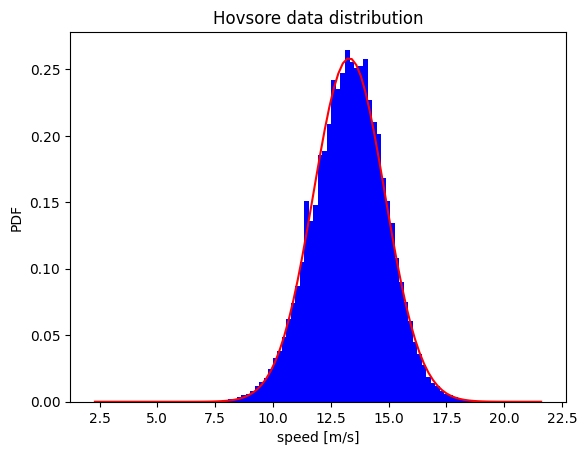

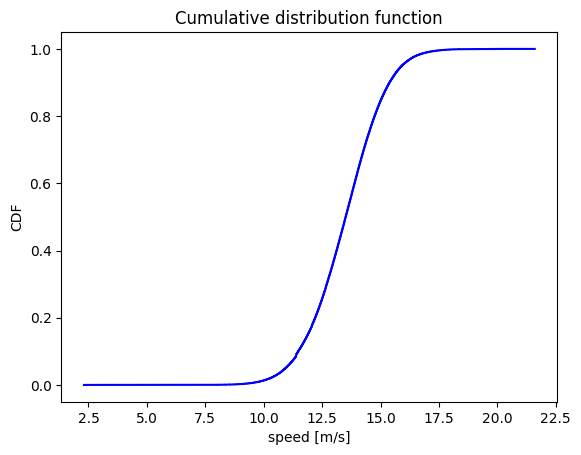

In [5]:
# HOVSORE

hov = pd.read_csv('hovsore_1.txt', delimiter=',', header=None)

hov_mean = np.mean(hov[1])    #= mu
hov_std = np.std(hov[1])      #= sigma
print(f'Hovsore mean = {hov_mean:.2f} and std = {hov_std:.2f}')

num=100
plt.figure(1)
plot_histogram(array_data=hov[1], num=num, color='b', label='Histrogram')
plot_Gaussian(array_data=hov[1], mu=hov_mean,sig=hov_std, num=num, color='r', label='Gaussian')
plt.title("Hovsore data distribution")
plt.xlabel("speed [m/s]")
plt.ylabel("PDF")
plt.show()

plt.figure(2)
plot_CDF(hov[1], 'b', 'cumulative')
plt.title('Cumulative distribution function')
plt.xlabel("speed [m/s]")
plt.ylabel("CDF")
plt.show()

area under graph = 1.00000


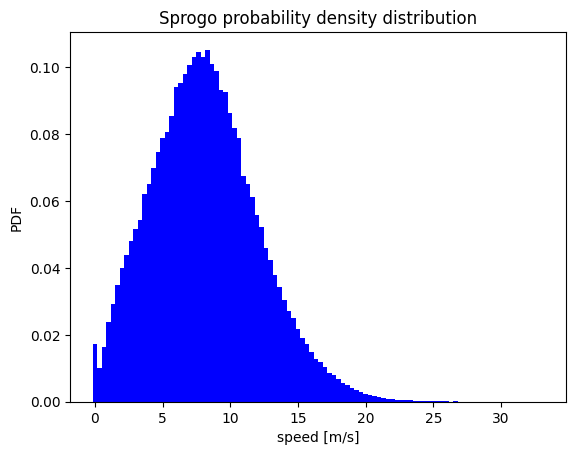

Text(0, 0.5, 'CDF')

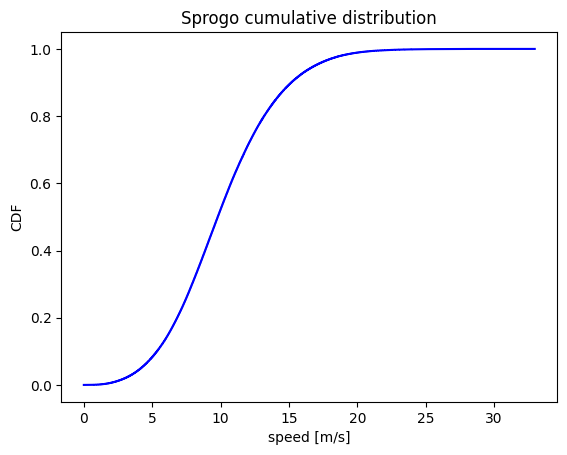

In [6]:
# SPROGO

datas = pd.read_csv('sprog.tsv', delimiter='\t', header=None, 
                    names=['t','V','dir67', 'dir70'])

time_all = datas['t'].values
V_all = datas['V'].values
dir67_all = datas['dir67'].values
dir70_all = datas['dir70'].values

V_array = []
dir_array = []
time_array = []
for i in range(len(V_all)):
    if V_all[i] < 90:
        if dir67_all[i] < 900:
            V_array.append(V_all[i])
            dir_array.append(dir67_all[i])
            time_array.append(time_all[i])
        elif dir70_all[i] < 900:
            V_array.append(V_all[i])
            dir_array.append(dir70_all[i])
            time_array.append(time_all[i])

V_array = np.array(V_array)
dir_array = np.array(dir_array)
time_array = np.array(time_array)



num=100
plt.figure(1)
plot_histogram(array_data=V_array, num=num, color='b', label='Histrogram')
plt.title("Sprogo probability density distribution")
plt.xlabel("speed [m/s]")
plt.ylabel("PDF")
plt.show()

plt.figure(2)
plot_CDF(V_array, 'b', 'cumulative')
plt.title("Sprogo cumulative distribution")
plt.xlabel("speed [m/s]")
plt.ylabel("CDF")


2.226489748056938 9.285860413569754
area under graph = 1.00000


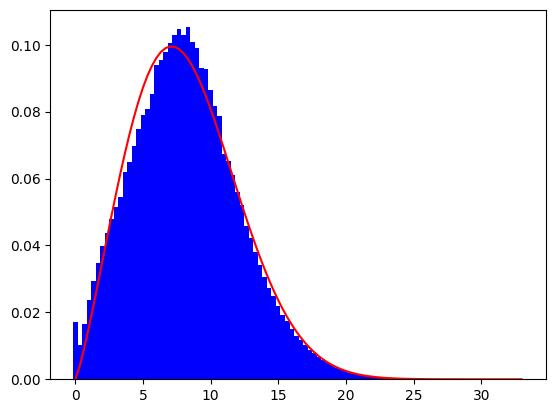

In [8]:
# WEIBULL DISTRIBUTION

k_tot, lam_tot = compute_Weibull_parameters(V_array)
print(k_tot, lam_tot)

plt.figure(1)
plot_histogram(array_data=V_array, num=num, color='b', label='Histrogram')
plot_Weibull(array_data=V_array, k=k_tot, lam=lam_tot, color='r', label='weibull')



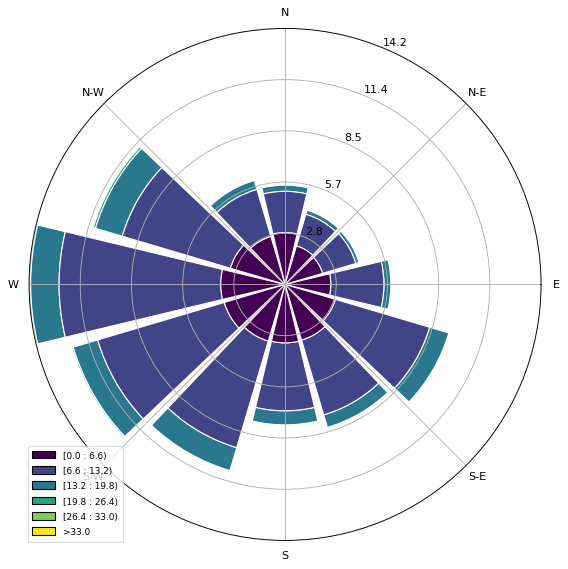

In [10]:
# WIND ROSE

ax = WindroseAxes.from_ax()
ax.bar(dir_array, V_array, normed=True, opening=0.9, edgecolor='white', nsector=12)
ax.set_legend()


for sector 0: k = 1.92 and lam = 7.77
for sector 1: k = 1.88 and lam = 7.59
for sector 2: k = 1.94 and lam = 7.60
for sector 3: k = 2.15 and lam = 8.36
for sector 4: k = 2.35 and lam = 9.73
for sector 5: k = 2.20 and lam = 8.90
for sector 6: k = 2.05 and lam = 8.85
for sector 7: k = 2.36 and lam = 9.80
for sector 8: k = 2.47 and lam = 9.92
for sector 9: k = 2.66 and lam = 10.06
for sector 10: k = 2.38 and lam = 10.20
for sector 11: k = 1.98 and lam = 8.45


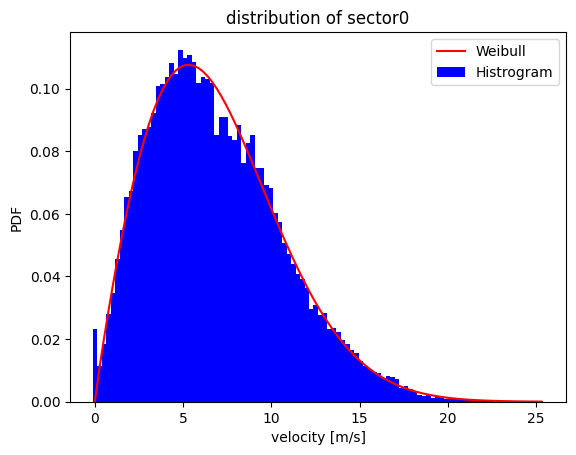

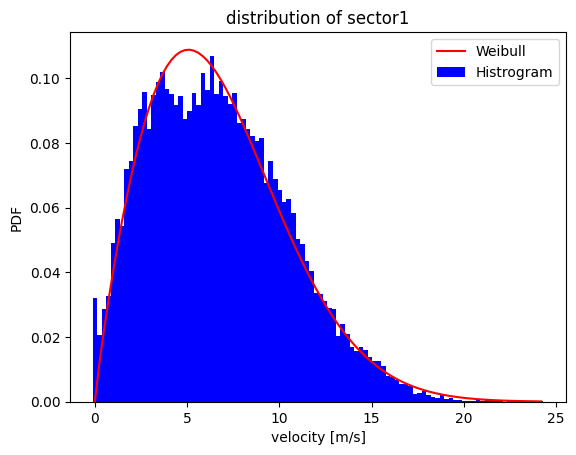

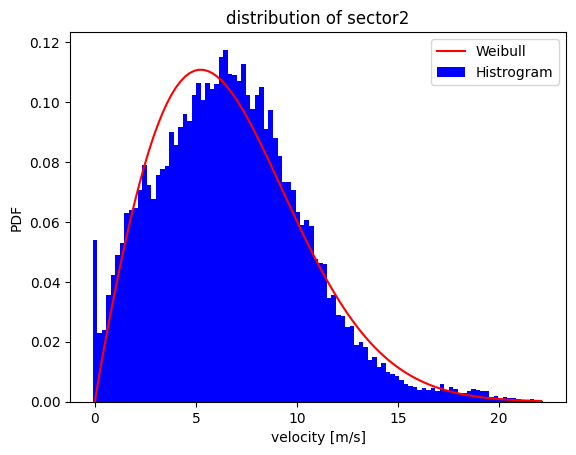

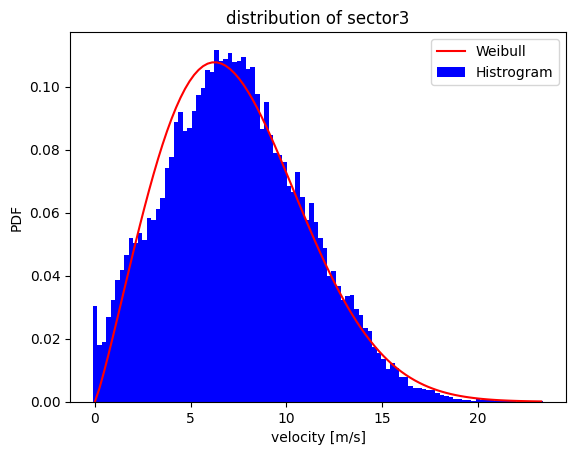

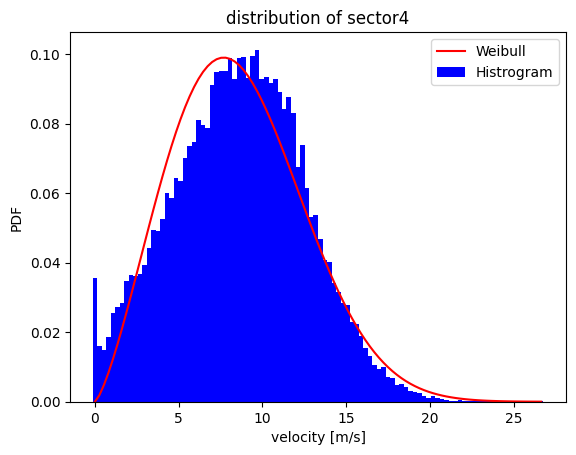

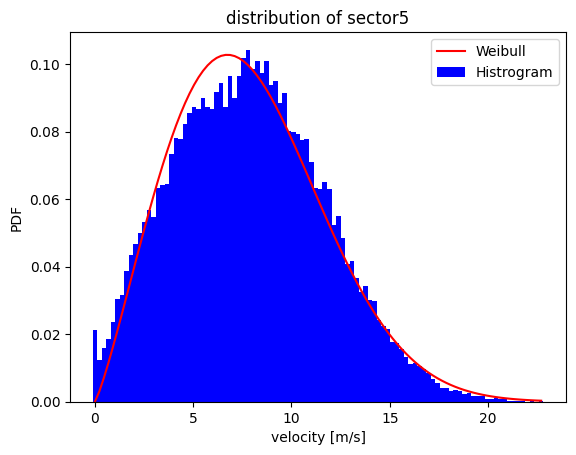

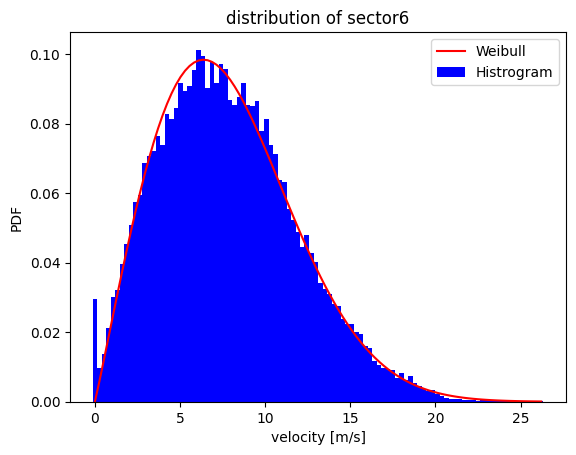

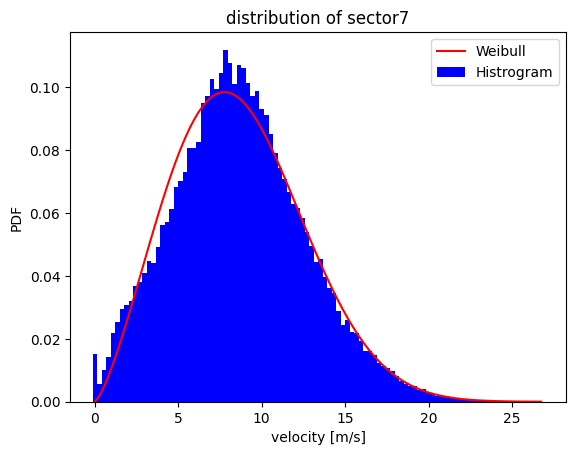

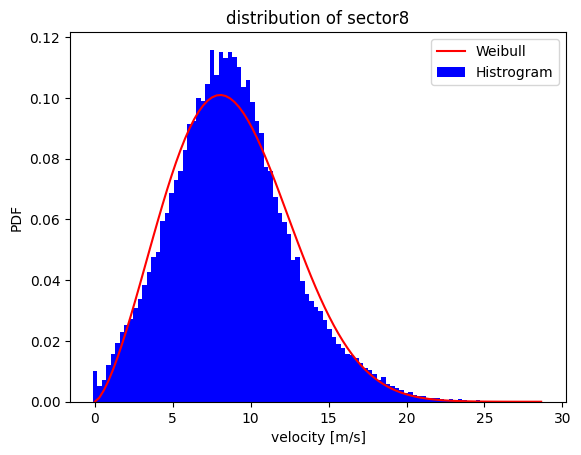

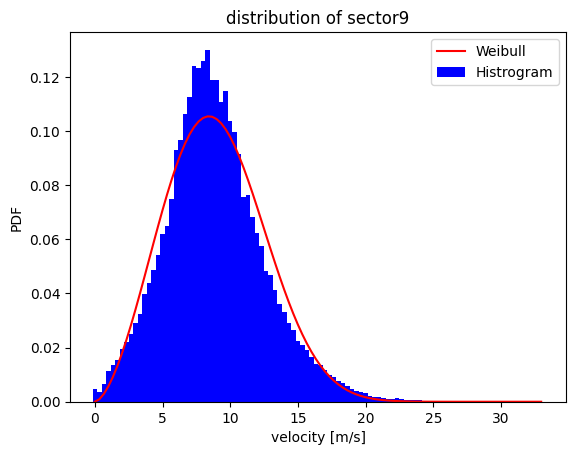

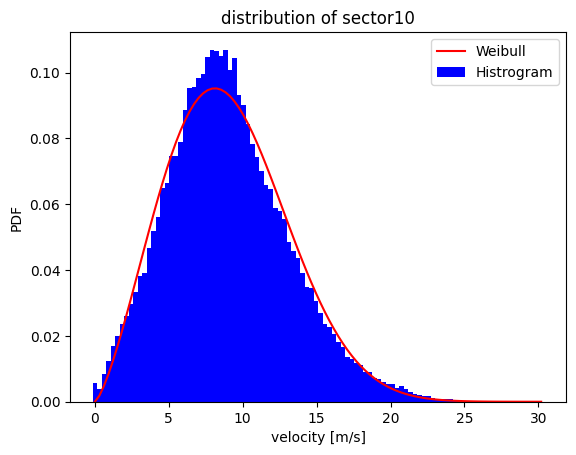

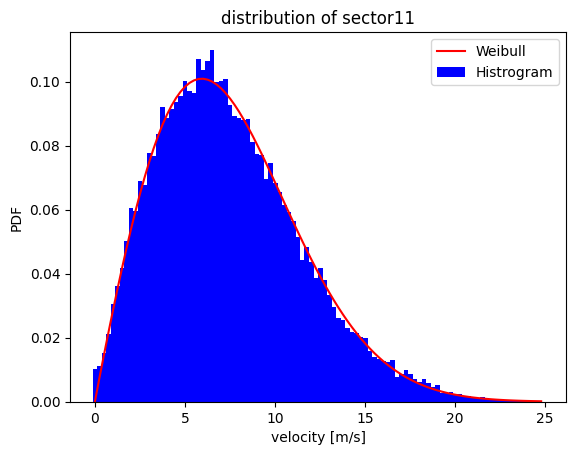

In [15]:
# DIVIDE IN SECTOR

data_sector = divide_in_sector(velocity=V_array, direction=dir_array, time=time_array)

counter = 0
for sector in data_sector:

    k, lam = compute_Weibull_parameters(sector)
    print(f'for sector {counter}: k = {k:.2f} and lam = {lam:.2f}')

    plt.figure(counter)
    plot_histogram(array_data=sector, num=num, color='b', label='Histrogram')
    plot_Weibull(array_data=sector, k=k, lam=lam, color='r', label='Weibull')
    plt.xlabel('velocity [m/s]')
    plt.ylabel('PDF')
    title = 'distribution of sector' + str(counter)
    plt.title(title)
    plt.legend()

    counter = counter+1
    
    

In [70]:

def divide_in_day(V_array, time_array, dir_array):
    tot_velocities = len(V_array)

    velocity_by_day = {}
    direction_by_day = {}

    for i in range(len(V_array)):
        minute = str(time_array[i])[-4:]

        if minute not in velocity_by_day:
            velocity_by_day[minute] = []
            direction_by_day[minute] = []
        velocity_by_day[minute].append(V_array[i])
        direction_by_day[minute].append(dir_array[i])
    
    minute_array = []
    mean_array = []
    std_array = []

    for minute, velocities in velocity_by_day.items():
        mean_velocity = np.mean(velocities)
        std_velocity = np.std(velocities)
        minute_array.append(minute)
        mean_array.append(mean_velocity)
        std_array.append(std_velocity)

    minute_array = np.array(minute_array )
    mean_array   = np.array(mean_array   )
    std_array    = np.array(std_array    )


    indices_time = np.argsort(minute_array)[::]
    minute_sort1 = minute_array[indices_time]
    minute_sort = minute_sort1.astype(int)
    mean_sort = mean_array[indices_time]
    std_sort = std_array[indices_time]

    return minute_sort, mean_sort, std_sort

    

minute_array, minute_mean_array, minute_std_array = divide_in_day(V_array, time_array, dir_array) 

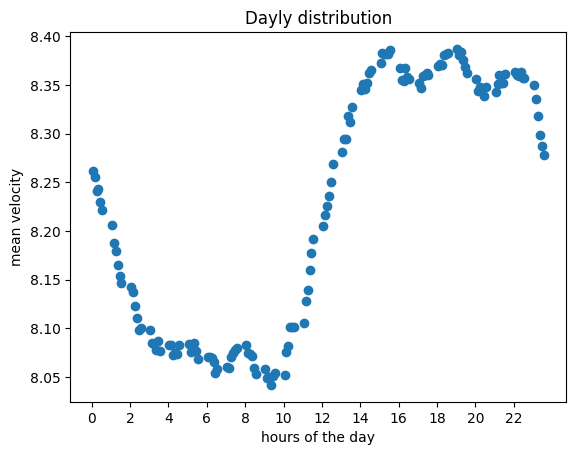

In [71]:
# plot dayly distribution

ticks_position = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200]
ticks_name = ['0', '2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22']

plt.figure(1)
plt.scatter(x=minute_array, y=minute_mean_array)
plt.xticks(ticks_position, ticks_name)
plt.title('Dayly distribution')
plt.xlabel('hours of the day')
plt.ylabel('mean velocity')

plt.show()


In [74]:
def divide_in_month(V_array, time_array, dir_array):
    tot_velocities = len(V_array)

    velocity_by_day = {}
    direction_by_day = {}

    for i in range(len(V_array)):
        minute = str(time_array[i])[4:6]

        if minute not in velocity_by_day:
            velocity_by_day[minute] = []
            direction_by_day[minute] = []
        velocity_by_day[minute].append(V_array[i])
        direction_by_day[minute].append(dir_array[i])
    
    minute_array = []
    mean_array = []
    std_array = []

    for minute, velocities in velocity_by_day.items():
        mean_velocity = np.mean(velocities)
        std_velocity = np.std(velocities)
        minute_array.append(minute)
        mean_array.append(mean_velocity)
        std_array.append(std_velocity)

    minute_array = np.array(minute_array )
    mean_array   = np.array(mean_array   )
    std_array    = np.array(std_array    )


    indices_time = np.argsort(minute_array)[::]
    minute_sort1 = minute_array[indices_time]
    month_sort = minute_sort1.astype(int)
    mean_sort = mean_array[indices_time]
    std_sort = std_array[indices_time]

    return month_sort, mean_sort, std_sort

month_array, month_mean_array, month_std_array = divide_in_month(V_array, time_array, dir_array)

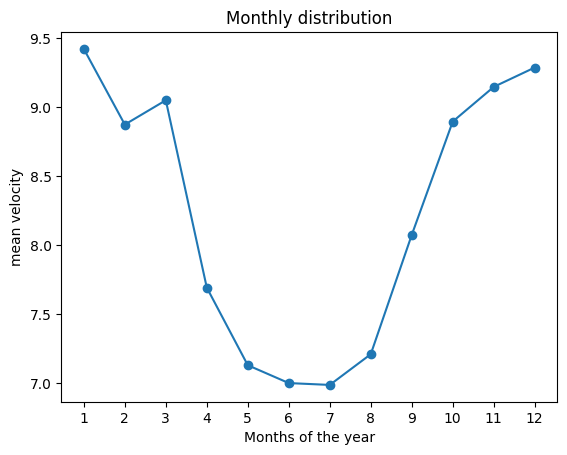

In [79]:
# plot montly distribution

ticks_position = [1, 2, 3, 4, 5, 6,7, 8, 9, 10, 11, 12]
ticks_name = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

plt.figure(1)
plt.scatter(x=month_array, y=month_mean_array)
plt.plot(month_array, month_mean_array)
plt.xticks(ticks_position, ticks_name)
plt.title('Monthly distribution')
plt.xlabel('Months of the year')
plt.ylabel('mean velocity')

plt.show()
